# Neumann Boundary Conditions with Arbitrary Domains 

In [1]:
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, Monitor2D, PredefinedExampleGenerator2D, set_default_dtype
from neurodiffeq.pde import CustomBoundaryCondition, Point, DirichletControlPoint, NeumannControlPoint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
set_default_dtype(torch.float64)

# The Problem
<img src="problem-b-1.png" alt="drawing" width="500"/>
<img src="problem-b-2.png" alt="drawing" width="500"/>
<img src="problem-c-1.png" alt="drawing" width="500"/>

# Trial Solution
<img src="problem-c-2.png" alt="drawing" width="500"/>

* $A_D(\vec{x})$: function that satisfy the Dirichlet boundary condition on the boundary
* $L_D(\vec{x})$ indicates how far away is $\vec{x}$ from the Dirichlet booundary condition, $L_D(\vec{x}) = 0$ on Dirichlet boundary. 
* $L_M(\vec{x})$ indicates how far away is $\vec{x}$ from the Neumann booundary condition, $L_M(\vec{x}) = 0$ on Neumann boundary. 
* $g(\vec{x})$ is the $g(\vec{x})$ in $\hat n(\vec{x}) \cdot \nabla u = g(\vec{x})$, where $\hat n(\vec{x})$ is the normal vector at $\vec{x}$
* $N$ is the output of the neural net
* $x_k$ is the $k-th$ dimension of $\vec{x}$
* $n_k$ is the $k-th$ dimension of the normal vector at $\vec{x}$ (on Neumann boundary, but should also be defined outside the Neumann boundary so that out trial solution can be evaluated outside the Neumann boundary as well)
* $F$ is $L_D(\vec{x})N$
* The $K(1-e^{1-L_M(\vec{x})})$ is for avoiding division by zero.

Users will specify the Dirichlet boundary condition by points $\vec{x}_i$ and their function value$\psi(\vec{x}_i)$ on the boundary (Dirichlet control points). Neumann boundary condition is specified by points $\vec{x}_i$ and their normal vector $\hat n(\vec{x})$ and their  normal derivative $\hat n(\vec{x}) \cdot \nabla u = g(\vec{x})$ on the boundary (Neumann control points).

We take these points, fit $A_D(\vec{x})$, $L_D(\vec{x})$, $L_M(\vec{x})$, $g(\vec{x})$, $n_k$ (k=1, 2) by thin plate spline, and create the trail solution.

In [3]:
RETRAIN_PROBLEM_C = True

In [4]:
def solution_analytical_problem_c(x, y):
    return np.log(1+x**2+y**2)

def gradient_solution_analytical_problem_c(x, y):
    return 2*x / (1+x**2+y**2), 2*y / (1+x**2+y**2), 

In [5]:
# creating control points for Dirichlet boundary conditions

edge_length = 2.0 / np.sin(np.pi/3) / 4
points_on_each_edge = 11
step_size = edge_length / (points_on_each_edge-1)

direction_theta  =  np.pi*2/3
left_turn_theta  =  np.pi*1/3
right_turn_theta = -np.pi*2/3

dirichlet_control_points_problem_c = []
point_x, point_y = 0.0, -1.0
for i_edge in range(6):
    for i_step in range(points_on_each_edge-1):
        dirichlet_control_points_problem_c.append(
            DirichletControlPoint(
                loc=(point_x, point_y), 
                val=solution_analytical_problem_c(point_x, point_y)
            )
        ) 
        point_x += step_size*np.cos(direction_theta)
        point_y += step_size*np.sin(direction_theta)
    direction_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta

# dummy control points to form closed domain    

radius_circle = 1.0 / np.sin(np.pi/6)
center_circle_x = radius_circle * np.cos(np.pi/6)
center_circle_y = 0.0

dirichlet_control_points_problem_c_dummy = []
for theta in np.linspace(-np.pi*5/6, np.pi*5/6, 60):
    point_x = center_circle_x + radius_circle*np.cos(theta)
    point_y = center_circle_y + radius_circle*np.sin(theta)
    dirichlet_control_points_problem_c_dummy.append(
        DirichletControlPoint(
            loc=(point_x, point_y),
            val=solution_analytical_problem_c(point_x, point_y)
        )
    )
    
# all Dirichlet control points

dirichlet_control_points_problem_c_all = \
    dirichlet_control_points_problem_c + dirichlet_control_points_problem_c_dummy

In [6]:
# creating control points for Neumann boundary condition

edge_length = 2.0 / np.sin(np.pi/3) / 4
points_on_each_edge = 11
step_size = edge_length / (points_on_each_edge-1)

normal_theta = np.pi/6

direction_theta  = -np.pi*1/3
left_turn_theta  =  np.pi*1/3
right_turn_theta = -np.pi*2/3

neumann_control_points_problem_c = []
point_x, point_y = 0.0, 1.0
for i_edge in range(6):
    normal_x = np.cos(normal_theta)
    normal_y = np.sin(normal_theta)
    
    # skip the points on the "tip", their normal vector is undefined?
    point_x += step_size*np.cos(direction_theta)
    point_y += step_size*np.sin(direction_theta)
    
    for i_step in range(points_on_each_edge-2):
        grad_x, grad_y = gradient_solution_analytical_problem_c(point_x, point_y)
        neumann_val = grad_x*normal_x + grad_y*normal_y
        neumann_control_points_problem_c.append(
            NeumannControlPoint(
                loc=(point_x, point_y), 
                val=neumann_val,
                normal_vector=(normal_x, normal_y)
            )
        ) 
        point_x += step_size*np.cos(direction_theta)
        point_y += step_size*np.sin(direction_theta)
    direction_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta
    normal_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta

# dummy control points to form closed domain
    
radius_circle = 1.0 / np.sin(np.pi/6)
center_circle_x = -radius_circle * np.cos(np.pi/6)
center_circle_y = 0.0

neumann_control_points_problem_c_dummy = []
for theta in np.linspace(np.pi*1/6, np.pi*11/6, 60):
    point_x = center_circle_x + radius_circle*np.cos(theta)
    point_y = center_circle_y + radius_circle*np.sin(theta)
    normal_x = np.cos(theta)
    normal_y = np.sin(theta)
    grad_x, grad_y = gradient_solution_analytical_problem_c(point_x, point_y)
    neumann_val = grad_x*normal_x + grad_y*normal_y
    neumann_control_points_problem_c_dummy.append(
        NeumannControlPoint(
                loc=(point_x, point_y), 
                val=neumann_val,
                normal_vector=(normal_x, normal_y)
        )
    )
    
# all Neumann control points

neumann_control_points_problem_c_all = \
    neumann_control_points_problem_c + neumann_control_points_problem_c_dummy

Because of the way the term $L_D(\vec{x})$ and $L_M(\vec{x})$ is created, we need the Dirichlet control points to form a closed domain on their own. We need the Neumann control points to form a closed domain on their own as well. Therefore, we actually create these control points.

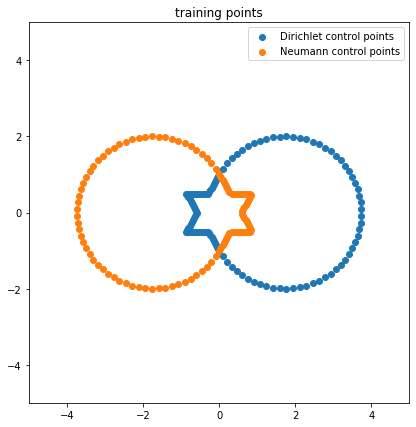

In [7]:
plt.figure(figsize=(7, 7))
plt.scatter(
    [p.loc[0] for p in dirichlet_control_points_problem_c_all],
    [p.loc[1] for p in dirichlet_control_points_problem_c_all],
    label='Dirichlet control points'
)
plt.scatter(
    [p.loc[0] for p in neumann_control_points_problem_c_all],
    [p.loc[1] for p in neumann_control_points_problem_c_all],
    label='Neumann control points'
)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('training points');

The actual domain we are solving is the intersection of these two domain.

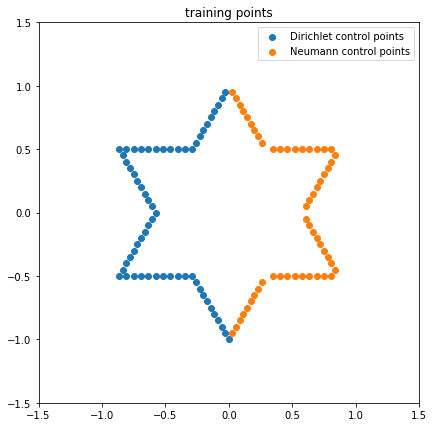

In [8]:
plt.figure(figsize=(7, 7))
plt.scatter(
    [p.loc[0] for p in dirichlet_control_points_problem_c],
    [p.loc[1] for p in dirichlet_control_points_problem_c],
    label='Dirichlet control points'
)
plt.scatter(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c],
    label='Neumann control points'
)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('training points');

In [9]:
cbc_problem_c = CustomBoundaryCondition(
    center_point=Point(loc=(0.0, 0.0)),
    dirichlet_control_points=dirichlet_control_points_problem_c_all,
    neumann_control_points=neumann_control_points_problem_c_all
)

Some sanity check on the fitted terms:

## $A_D(\vec{x})$

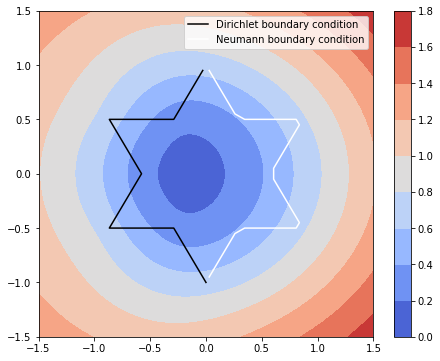

In [10]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
a_ds = cbc_problem_c.a_d(xx, yy)
a_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))

plt.plot(
    [p.loc[0] for p in dirichlet_control_points_problem_c],
    [p.loc[1] for p in dirichlet_control_points_problem_c],
    label='Dirichlet boundary condition', color='black'
)
plt.plot(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c],
    label='Neumann boundary condition', color='white'
)
plt.legend()

cs = ax.contourf(xx, yy, a_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

## $L_D(\vec{x})$

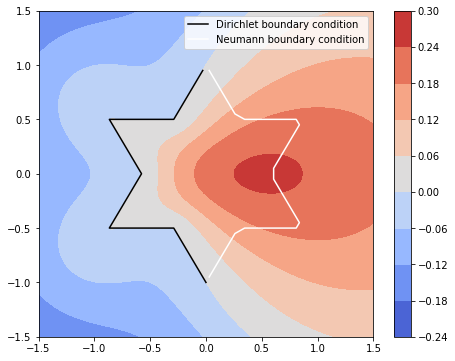

In [11]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ds = cbc_problem_c.l_d(xx, yy)
l_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))

plt.plot(
    [p.loc[0] for p in dirichlet_control_points_problem_c],
    [p.loc[1] for p in dirichlet_control_points_problem_c],
    label='Dirichlet boundary condition', color='black'
)
plt.plot(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c],
    label='Neumann boundary condition', color='white'
)
plt.legend()

cs = ax.contourf(xx, yy, l_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

## $A_M(\vec{x})$

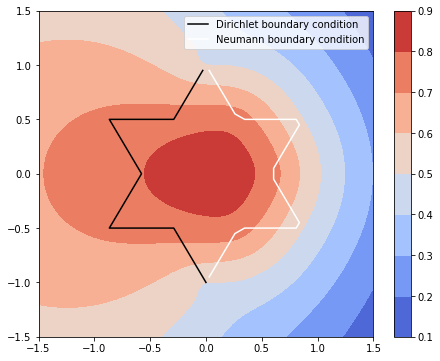

In [12]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
gs = cbc_problem_c.g(xx, yy)
gs.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))

plt.plot(
    [p.loc[0] for p in dirichlet_control_points_problem_c],
    [p.loc[1] for p in dirichlet_control_points_problem_c],
    label='Dirichlet boundary condition', color='black'
)
plt.plot(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c],
    label='Neumann boundary condition', color='white'
)
plt.legend()

cs = ax.contourf(xx, yy, gs, cmap='coolwarm')
cbar = fig.colorbar(cs)

## $L_M(\vec{x})$

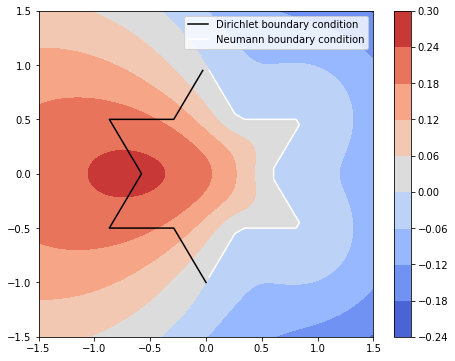

In [13]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ms = cbc_problem_c.l_m(xx, yy)
l_ms.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))

plt.plot(
    [p.loc[0] for p in dirichlet_control_points_problem_c],
    [p.loc[1] for p in dirichlet_control_points_problem_c],
    label='Dirichlet boundary condition', color='black'
)
plt.plot(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c],
    label='Neumann boundary condition', color='white'
)
plt.legend()

cs = ax.contourf(xx, yy, l_ms, cmap='coolwarm')
cbar = fig.colorbar(cs)

In [14]:
def get_grid(x_from_to, y_from_to, x_n_points=100, y_n_points=100, as_tensor=False):
    x_from, x_to = x_from_to
    y_from, y_to = y_from_to
    if as_tensor:
        x = torch.linspace(x_from, x_to, x_n_points)
        y = torch.linspace(y_from, y_to, y_n_points)
        return torch.meshgrid(x, y)
    else:
        x = np.linspace(x_from, x_to, x_n_points)
        y = np.linspace(y_from, y_to, y_n_points)
        return np.meshgrid(x, y)

def to_np(tensor):
    return tensor.detach().numpy()

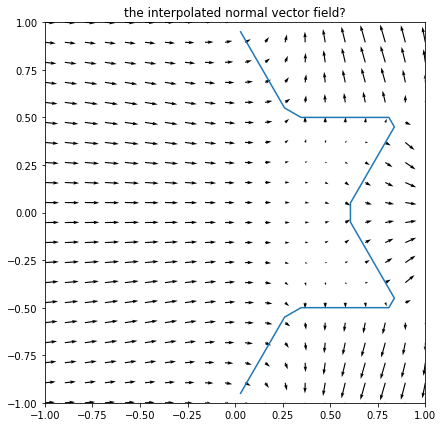

In [15]:
x = torch.linspace(-1, 1, 20)
y = torch.linspace(-1, 1, 20)
xx, yy = torch.meshgrid(x, y)
xx_normal_vector, yy_normal_vector = cbc_problem_c.n_hat(xx, yy)
xx_normal_vector = to_np(xx_normal_vector)
yy_normal_vector = to_np(yy_normal_vector)

fig, ax = plt.subplots(figsize=(7, 7))
ax.quiver(xx, yy, xx_normal_vector, yy_normal_vector)
ax.plot(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c]
)
        
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('the interpolated normal vector field?')
plt.show()

In [16]:
xx_train, yy_train = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=28, y_n_points=28,
    as_tensor=True
)
is_in_domain_train = cbc_problem_c.in_domain(xx_train, yy_train)
xx_train, yy_train = to_np(xx_train), to_np(yy_train)
xx_train, yy_train = xx_train[is_in_domain_train], yy_train[is_in_domain_train]
train_gen = PredefinedExampleGenerator2D(xx_train, yy_train)

xx_valid, yy_valid = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=100, y_n_points=100,
    as_tensor=True
)
is_in_domain_valid = cbc_problem_c.in_domain(xx_valid, yy_valid)
xx_valid, yy_valid = to_np(xx_valid), to_np(yy_valid)
xx_valid, yy_valid = xx_valid[is_in_domain_valid], yy_valid[is_in_domain_valid]
valid_gen = PredefinedExampleGenerator2D(xx_valid, yy_valid)

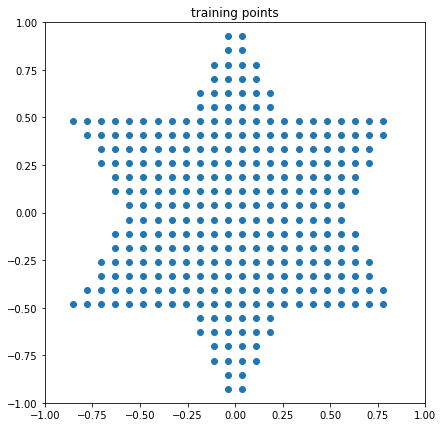

In [17]:
plt.figure(figsize=(7, 7))
plt.scatter(xx_train, yy_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('training points');

<IPython.core.display.Javascript object>


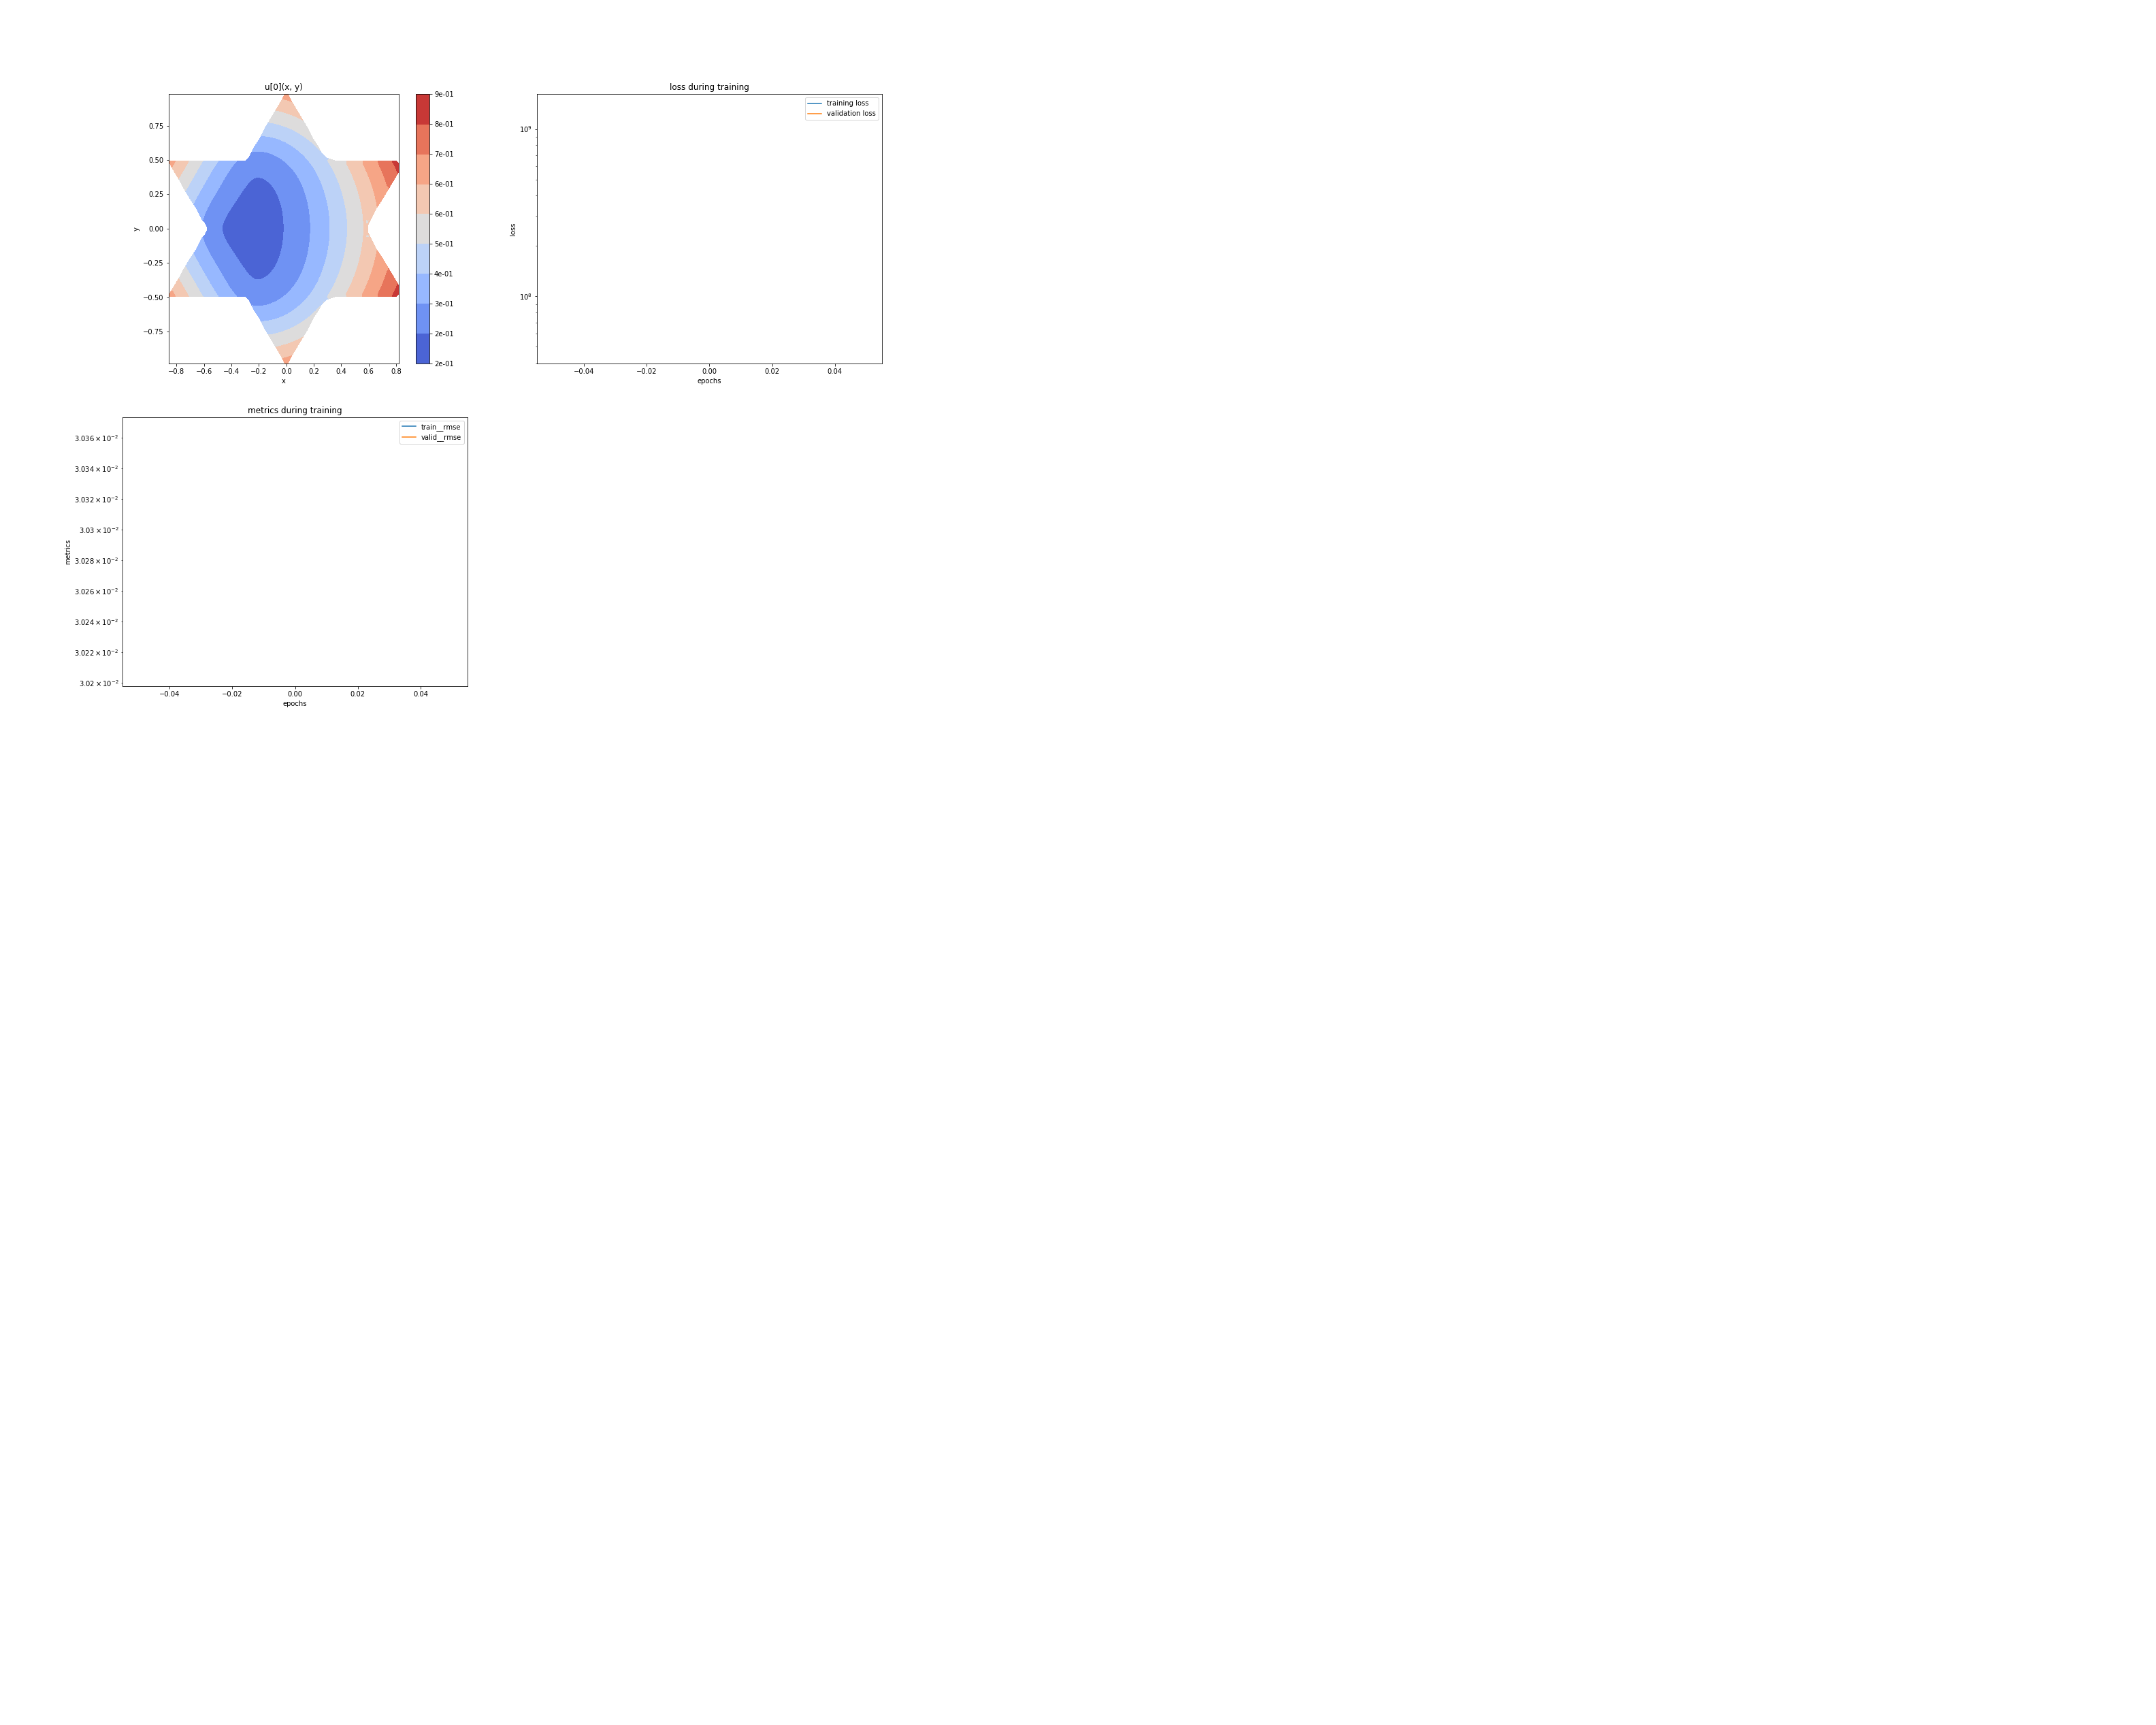

In [18]:
%matplotlib notebook
if RETRAIN_PROBLEM_C:
    
    def rmse(u, x, y):
        true_u = torch.log(1+x**2+y**2)
        return torch.mean( (u - true_u)**2 )
    
    # nabla^2 psi(x, y) = (e^(-x))(x-2+y^3+6y)
    def de_problem_c(u, x, y):
        return diff(u, x, order=2) + diff(u, y, order=2) + torch.exp(u) - 1.0 - x**2 - y**2 - 4.0/(1.0+x**2+y**2)**2

    # fully connected network with one hidden layer (40 hidden units with Sigmoid activation)
    net = FCNN(n_input_units=2, n_hidden_units=40, n_hidden_layers=1, actv=nn.Sigmoid)
    adam = optim.Adam(params=net.parameters(), lr=0.01)

    # train on 28 X 28 grid
    solution_neural_net_problem_c, history_problem_c = solve2D(
        pde=de_problem_c, condition=cbc_problem_c,
        xy_min=(-1, -1), xy_max=(1, 1),
        train_generator=train_gen, valid_generator=valid_gen,
        net=net, max_epochs=1, batch_size=train_gen.size, optimizer=adam,
        monitor=Monitor2D(check_every=1, xy_min=(-1, -1), xy_max=(1, 1), valid_generator=valid_gen),
        metrics={'rmse': rmse}
    )
%matplotlib inline

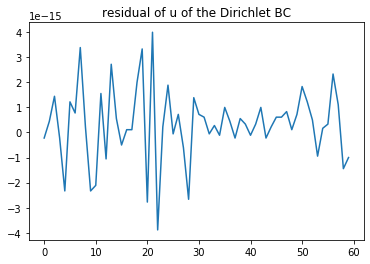

In [19]:
xs = torch.tensor([p.loc[0] for p in dirichlet_control_points_problem_c], requires_grad=True).reshape(-1, 1)
ys = torch.tensor([p.loc[1] for p in dirichlet_control_points_problem_c], requires_grad=True).reshape(-1, 1)
us = solution_neural_net_problem_c(xs, ys, as_type='np')
true_us = solution_analytical_problem_c( to_np(xs),  to_np(ys) )

plt.plot(us - true_us)
plt.title('residual of u of the Dirichlet BC');

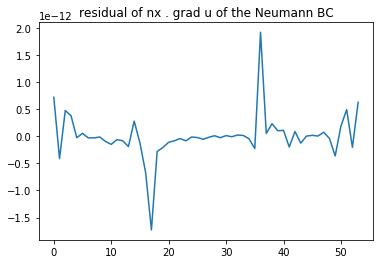

In [20]:
xs = torch.tensor([p.loc[0] for p in neumann_control_points_problem_c], requires_grad=True).reshape(-1, 1)
ys = torch.tensor([p.loc[1] for p in neumann_control_points_problem_c], requires_grad=True).reshape(-1, 1)
us = solution_neural_net_problem_c(xs, ys)
nxs = torch.tensor([p.normal_vector[0] for p in neumann_control_points_problem_c]).reshape(-1, 1)
nys = torch.tensor([p.normal_vector[1] for p in neumann_control_points_problem_c]).reshape(-1, 1)

normal_derivative = to_np( nxs * diff(us, xs) + nys * diff(us, ys) ).flatten()
true_normal_derivative = np.array([p.val for p in neumann_control_points_problem_c])

plt.plot(normal_derivative - true_normal_derivative)
plt.title('residual of nx . grad u of the Neumann BC');